<a href="https://colab.research.google.com/github/zeynabyousefi/Assignment_Pytorch_sample_task_Sentiment_Analysis./blob/main/Assignment_Pytorch_sample_task_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment analysis** is a widely used technique for `text classification` that aims to determine the underlying polarity of text content, such as positive or negative sentiment. This can be achieved through a binary classification approach, such as a like/dislike rating, or a more nuanced approach, such as a star rating on a scale of 1 to 5. Examples of sentiment analysis include analyzing Twitter posts, or extracting the general perception of a new brand of Samsung Mobiles from customer reviews on Digikala's website.

This exercise is designed to impart some of the most effective machine learning practices for solving `text classification` problems.

You will learn about the `end-to-end workflow` for solving `text classification` problems using machine learning, as well as how to select the most appropriate model for your particular task.

Additionally, you will gain practical experience in implementing your chosen model using the popular deep learning framework, `PyTorch`.

In [1]:
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import torch

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1. Play with Data

In [2]:
!gdown https://drive.google.com/uc?id=1dW2xWQFOrhe4qc7ejNboVoRo9nJxB-H4
!gdown https://drive.google.com/uc?id=1dCBlZNSYLW4ch8WqL9Ro2dhSth1V6nPg

Downloading...
From: https://drive.google.com/uc?id=1dW2xWQFOrhe4qc7ejNboVoRo9nJxB-H4
To: /content/test_sst2.json
100% 124k/124k [00:00<00:00, 31.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dCBlZNSYLW4ch8WqL9Ro2dhSth1V6nPg
To: /content/train_sst2.json
100% 6.15M/6.15M [00:00<00:00, 116MB/s]


It is advisable to perform checks on data after loading it by manually selecting a few samples and ensuring consistency with expectations, such as verifying if the sentiment label matches the given review, as exemplified by a randomly selected negative review from the dataset.

In [3]:
from sklearn.utils import validation
train_data = pd.read_json("train_sst2.json", lines=True)
test_data = pd.read_json("test_sst2.json", lines=True)
train_data, validation_data = train_test_split(train_data, test_size=0.1, random_state=8, stratify=train_data[['label']])
train_data

,idx,sentence,label
24460,24460,is a decomposition of healthy eccentric inspir...,0
22271,22271,america 's knee-jerk moral sanctimony,0
1738,1738,"proved too difficult a text to ` lick , ' desp...",0
42045,42045,"terminally bland , painfully slow",0
34518,34518,gives poor dana carvey nothing to do that is r...,0
...,...,...,...
16041,16041,write and deliver a one liner as well as anybody,1
14547,14547,"the evocative imagery and gentle , lapping rhy...",1
20515,20515,ca n't make up its mind whether it wants to be...,0
26118,26118,an amusing and unexpectedly insightful examina...,1


<font color="red">Write your observations about data here:</font>


## 1.1 Check Key Metrics

It's crucial to collect essential metrics that can help characterize the text classification problem. These metrics include the `total number of samples`, the `total number of classes`, `the number of samples per class`, `the median number of words per sample`, `the frequency distribution of words`, and `the distribution of sample length`.

<font color="red">So fill this form:
* **Total number of samples**                  _____________
* **Total number of classes**                  _____________
* **The number of samples per class**          _____________
* **The median number of words per sample**    _____________
* **The frequency distribution of words**      _____________
* **The distribution of sample length**        _____________

 </font>



In [4]:
def get_median_num_words_per_sample(texts: list):
  """
  Calculate the median number of words per sample in a given corpus.

  Args:
      texts (list): A list of sample texts.

  Returns:
      int: The median number of words per sample.
  """

  #################  2 Lines ################
  median_num_words = None
    # Calculate the number of words in each sample
  word_counts = [len(text.split()) for text in texts]

  # Sort the word counts in ascending order
  word_counts.sort()

  # Find the median of the word counts
  num_samples = len(word_counts)
  if num_samples % 2 == 1:
      # If the number of samples is odd, return the middle element as the median
      median_word_count = word_counts[num_samples // 2]
  else:
      # If the number of samples is even, average the two middle elements as the median
      mid_idx = num_samples // 2
      median_num_words = (word_counts[mid_idx - 1] + word_counts[mid_idx]) / 2

  ###########################################
  return median_num_words


def plot_texts_length_distribution(texts: list) -> None:

  """
  Plot the distribution of sample lengths by number of tokens.

  Args:
      texts (list): A list of texts.
  """
  ############################ 1 Line ########################
  num_words_per_text = None
  num_words_per_text = texts.str.split().str.len()
  ############################################################
  plt.hist(num_words_per_text, 50)
  plt.xlabel('Number of Tokens in Samples')
  plt.ylabel('Number of Samples')
  plt.title('Distribution of Sample Lengths')
  plt.show()



def plot_labels_distribution(labels: pd.DataFrame) -> int:
  """
  Plots the class distribution.

  Args:
      labels (list): A list of texts.
  """

  ################## 3 Lines #################
  counts = labels.value_counts()
  num_classes = len(counts)
  idx = np.arange(num_classes)

  #####################################################
  idx = np.arange(num_classes)
  plt.bar(idx, counts, width=0.8, color='b')
  plt.xlabel('Label')
  plt.ylabel('# Samples')
  plt.title('Label Distribution')
  plt.xticks(idx, idx)
  plt.show()

In [ ]:
get_median_num_words_per_sample(list(train_data['sentence']))

7.0

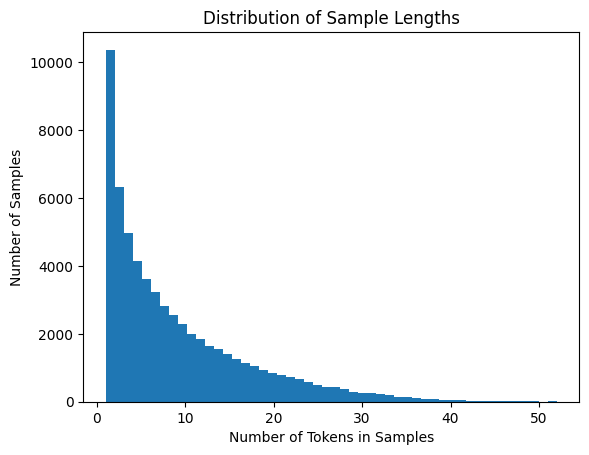

In [5]:
plot_texts_length_distribution(train_data['sentence'])

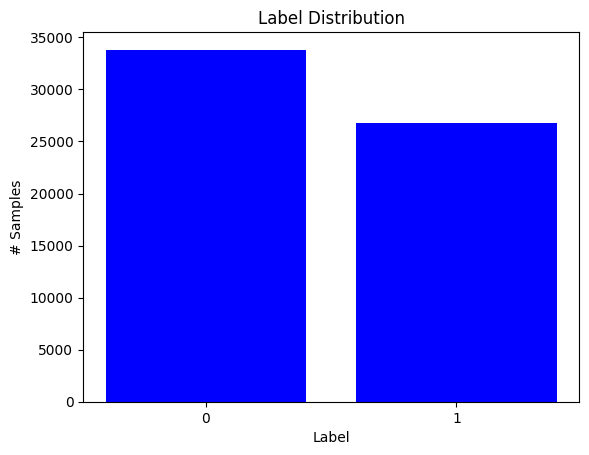

In [6]:
plot_labels_distribution(train_data['label'])

In [7]:
def plot_frequency_distribution(sample_texts, ngram_range=(1, 2), num_ngrams=10):
  """
  Plots the frequency distribution of words.

  # Arguments
  sample_texts: list, sample texts.
  ngram_range: tuple (min, max), The range of n-gram values to consider.
      Min and max are the lower and upper bound values for the range.
  num_ngrams: int, number of n-grams to plot.
      Top `num_ngrams` frequent n-grams will be plotted.
  """

  #######################  10 Lines  ################################
  """
    ~HELP~

          1. Create a CountVectorizer object
          2. Vectorize the sample texts
          3. Get the list of all n-grams in index order and calculate the total number of n-grams
              3.1. Ensure that num_ngrams is not greater than the total number of n-grams
          4. Calculate the frequency of all n-grams and sort them in descending order
          5. Separate the sorted n-grams and counts into separate lists
          6. Get the top num_ngrams n-grams and their frequencies

  """
  #Initialize the CountVectorizer with the specified n-gram range
  vectorizer = CountVectorizer(ngram_range=ngram_range)

  # Fit and transform the sample texts to get the n-gram frequencies
  ngram_counts = vectorizer.fit_transform(sample_texts)

  # Calculate the sum of n-gram occurrences
  ngram_occurrences = ngram_counts.sum(axis=0)

  # Get the n-grams and their corresponding frequencies
  ngrams = vectorizer.get_feature_names_out()
  frequencies = ngram_occurrences.tolist()[0]

  # Sort the n-grams by frequency in descending order
  sorted_ngrams, sorted_frequencies = zip(*sorted(zip(ngrams, frequencies), key=lambda x: x[1], reverse=True))

  # Select the top `num_ngrams` frequent n-grams
  top_ngrams = sorted_ngrams[:num_ngrams]
  top_frequencies = sorted_frequencies[:num_ngrams]

  ############################################################################


  # Plot the frequency distribution of n-grams
  idx = range(num_ngrams)
  plt.bar(idx, top_frequencies, width=0.8, color='b')
  plt.xlabel('N-grams')
  plt.ylabel('Frequencies')
  plt.title('Frequency Distribution of N-grams')
  plt.xticks(idx, top_ngrams, rotation=45)
  plt.show()



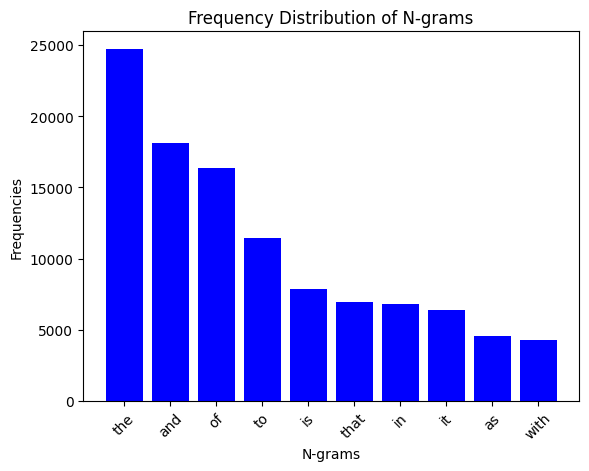

         idx                                           sentence  label
24460  24460  is a decomposition of healthy eccentric inspir...      0
22271  22271             america 's knee-jerk moral sanctimony       0
1738    1738  proved too difficult a text to ` lick , ' desp...      0
42045  42045                 terminally bland , painfully slow       0
34518  34518  gives poor dana carvey nothing to do that is r...      0
...      ...                                                ...    ...
16041  16041  write and deliver a one liner as well as anybody       1
14547  14547  the evocative imagery and gentle , lapping rhy...      1
20515  20515  ca n't make up its mind whether it wants to be...      0
26118  26118  an amusing and unexpectedly insightful examina...      1
59601  59601  is entertainment opportunism at its most glari...      0

[60614 rows x 3 columns]


In [8]:
plot_frequency_distribution(train_data['sentence'])
print(train_data)


In [9]:
def clean_text_column(input_df, col_name) -> pd.DataFrame:
    """
      Clean a text column in a pandas DataFrame.
      remove stopwords and lowercase text and so on ...
    """
    ##############frequencies####### 5 Lines #################
    input_df = pd.DataFrame(input_df)
    input_df[col_name] = input_df[col_name].astype(str)
    input_df[col_name] = input_df[col_name].str.lower().str.split()  # split the words
    stop_words = stopwords.words('english')  # load the stop words
    output_df = input_df[col_name].apply(
        lambda x: [item for item in x if item not in stop_words]).apply(' '.join)  # remove stopwords from dataframe


    ##################### 5 Lines #################
    return output_df

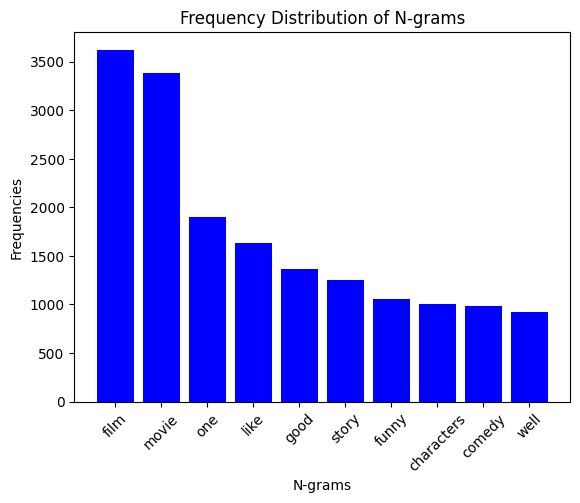

In [10]:
train_data = clean_text_column(train_data, 'sentence')
validation_data = clean_text_column(validation_data, 'sentence')
test_data = clean_text_column(test_data, 'sentence')
train_data = pd.DataFrame(train_data)
plot_frequency_distribution(train_data['sentence'])


## 1.2 Preparation Data

To prepare data for a model, it must be transformed into a format that the model can understand. Data samples may be in a specific order, so it's best to **shuffle** them to avoid influencing the relationship between texts and labels. Machine learning algorithms require numerical inputs, so texts must be converted into numerical vectors through **tokenization** and **vectorization**. This determines the vocabulary of the dataset and defines a numerical measure to characterize the texts.

### 1.2.1 Tokenization

Tokenization is the process of breaking down a text into individual words or sub-texts, called tokens. This is typically the first step in NLP.

In [23]:
def text_tokenize(text: str) -> list:
  """
  Split text to sub-texts (tokens)

  Args:
    text (str): input sentence for tokenization
  """
  ################# 1 Line ##############
  tokens = re.findall(r'[a-z]+|[.!?]|(?:(?![.!?])\S)+', text, re.I)
  ###########################################
  return tokens

assert text_tokenize("PART AI Company specializes in developing AI solutions that help businesses.") ==\
 ['PART', 'AI', 'Company', 'specializes', 'in', 'developing', 'AI', 'solutions', 'that', 'help', 'businesses', '.']


### 1.2.2 Vectorization

Vectorization refers to the process of representing textual data as numerical vectors that can be used as inputs to machine learning models. Vectorization is necessary because most machine learning algorithms operate on numerical data, and text data is inherently non-numeric.

There are various methods of vectorization in NLP, and one popular approach is word embedding. Word embedding is a way of representing words as dense vectors of real numbers, where each dimension of the vector represents a different feature of the word. By representing words as vectors, we can perform mathematical operations on them, such as calculating distances between words or analogies.




After tokenizing input texts, we assigned an ID to each token. The first layer in the model is the embedding layer, which creates a vector for each token.



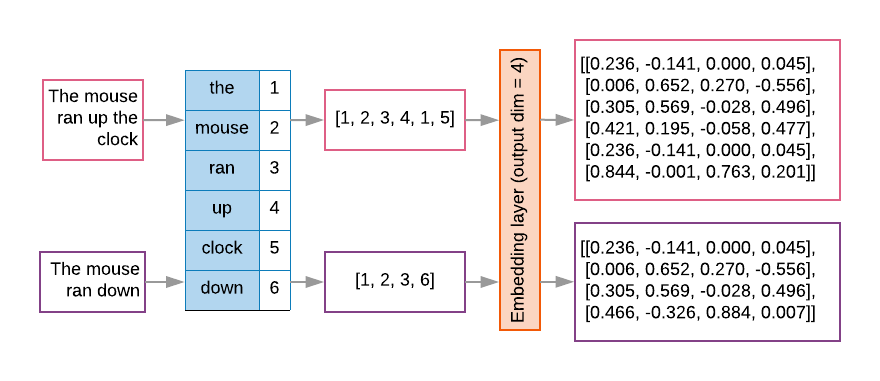

<font color="red"> What are the features of the best embedding method? </font>
-
-
-


## 2. Play with Embedding

In [24]:
! wget "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip" -O glove.6B.zip && unzip glove.6B.zip

--2023-07-26 07:16:28--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 18.164.124.11, 18.164.124.27, 18.164.124.99, ...
Connecting to huggingface.co (huggingface.co)|18.164.124.11|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1690609730&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MDYwOTczMH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=bnS8O2G029-yjAk8nZ5LBHxCa

We define some constants for this section.

In [26]:
EMBEDDING_DIM = 300
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

In [27]:
word2vec = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8') as f:
  ################### 5 Lines ############
    for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            word2vec[word] = embedding

  ##########################################
print(f"Loaded {len(word2vec)} word vectors.")

Loaded 400001 word vectors.


Initialize `UNK_TOKEN` and `PAD_TOKEN`

<font color="red"> What is your suggestion for this initialization and WHY? </font>

*


In [ ]:
######################  2 Lines #######################
word2vec[UNK_TOKEN] = None
word2vec[PAD_TOKEN] = None
##########################################################


In [ ]:
word2idx, idx2word = {}, {}
word2idx = {word: idx for idx, word in enumerate(word2vec)}
idx2word = {value: key for key, value in word2idx.items()}

Having obtained word vectors, it is necessary to have a means of measuring the similarity between individual words based on these vectors. One metric used for this purpose is **cosine similarity**, which is useful for identifying words that are either closely or distantly related. It is possible to view n-dimensional vectors as points in n-dimensional space, and **L1** and **L2** distances can be used to assess the distance between these points. Alternatively, the angle between two vectors can be analyzed, as demonstrated through trigonometry.

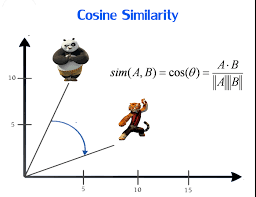

In [ ]:
def cosine_similarity(a: np.array, b: np.array) -> float:
  """

  Computes the cosine similarity between vectors a and b.

    Args:
      a: A NumPy array representing the first input vector.
      b: A NumPy array representing the second input vector.

    Returns:
      A float representing the cosine similarity between a and b.

  """
  ###################### 1 line #####################
  result = None
  ###########################################
  return result


assert round(cosine_similarity(np.ones(10), np.ones(10))) == 1
assert round(cosine_similarity(np.ones(10), - np.ones(10))) == -1
assert round(cosine_similarity(np.array([1, 0]), np.array([0, 1]))) == 0

In [ ]:
def get_most_similars(input_vec:np.array, topk:int=5) -> list:
  """
    Get Closest item to the given input_vec
    Args:
      input_vec: A NumPy array representing the input vector.

    Returns:
      A sorted list of similar words

  """

  ##################  5 Lines ##############

  #################################################
  return most_similars

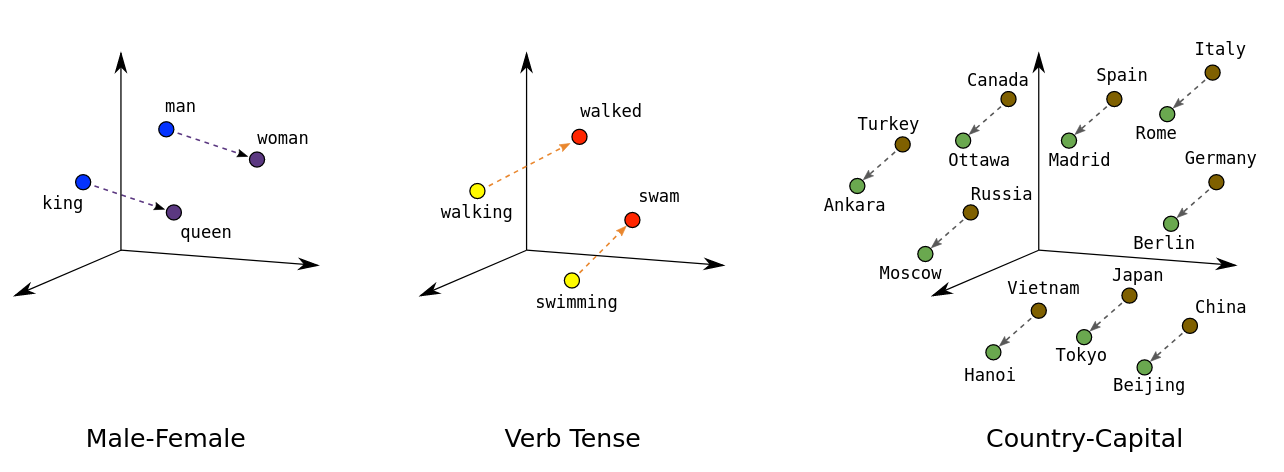

In [ ]:
def find_analogy(x1: str, x2: str, y1: str) -> list:
  """
  Find a word that is analogous to the relationship between two pairs of words.
  It uses the word embeddings provided by the word2vec dictionary to compute the analogy.

    Args:
      x1: the first word in the first pair
      x2: the second word in the first pair
      y1: the first word in the second pair


    Returns:
      A sorted list of similar words



  """
  ######################## ~ 5 Lines ###########################


  ####################################################
  return result


find_analogy("king", "man", "woman")


<ipython-input-19-c0f829df9a7b>:15: RuntimeWarning: invalid value encountered in float_scalars
  result = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


['king', 'queen', 'monarch', 'throne', 'princess']

We can use `principal component analysis` (**PCA**) to visualize words in a picture. **PCA** is a dimensionality reduction technique that can be used to reduce the **high-dimensional** vector representation of words in an embedding space to a **lower-dimensional** space while retaining the most important information.

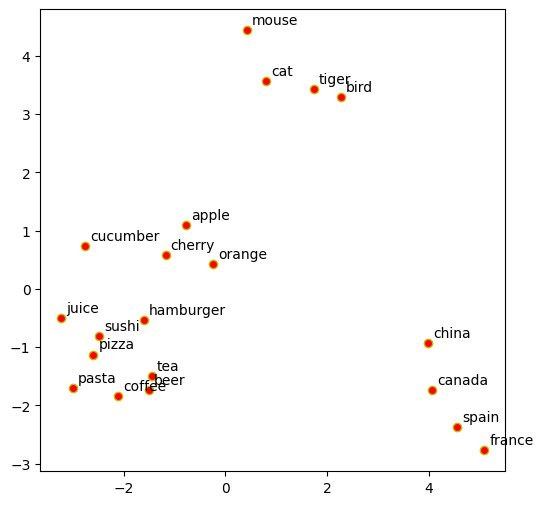

In [ ]:
words = ['bird', 'cat', 'mouse', 'tiger',
         'france', 'spain', 'canada', 'china',
         'pizza', 'pasta', 'hamburger', 'sushi',
         'tea', 'coffee', 'beer', 'juice',
         'cherry', 'apple', 'orange', 'cucumber'
         ]
########################### 2 Lines ###########################
word_vectors = None
pca_2dim = None
#############################################################
plt.figure(figsize=(6,6))
plt.scatter(pca_2dim[:, 0], pca_2dim[:, 1], edgecolors='y', c='r')
for word, (x,y) in zip(words, pca_2dim):
    plt.text(x+0.1, y+0.1, word)

# 3. Play with PyTorch

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import time


In [ ]:
"""
  Some constants for model
"""
BATCH_SIZE = 64
NUM_EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 1e-6
HIDDEN_SIZE = 512
VOCAB_SIZE = len(word2vec)
OUTPUT_DIM = 2
MAX_LEN = 20

In [ ]:
class TextDataset(torch.utils.data.Dataset):

  def __init__(self, df, word2idx, max_len=100):
    self.df = df
    self.max_len = max_len
    self.word2idx = word2idx

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    #######################################################
    label = None
    tokens None
    ########################################################
    return {'input_ids': torch.tensor(tokens), 'label': torch.tensor(label, dtype=torch.long)}

In [ ]:
class SentimentModel(nn.Module):
  def __init__(self, input_size, embedding_dim, output_dim, vector_matrix=None, pad_idx=word2idx['<pad>']):
    super().__init__()
    ##############################################
    """
          ~help~

      1. Define  Embedding layer for word embeddings
      2. Define Linear for classification
    """
    self.embedding = None
    self.fc = None
    ##############################################
    if vector_matrix is not None:
      self.init_weights(vector_matrix)

  def init_weights(self, vector_matrix):
    ##############################################
    # Initialize with the tensor as the weight of the embedding layer

    pass
    ##############################################

  def forward(self, text):
    """
    1. Pass the input text through the embedding layer
    2. Apply average pooling across the embeddings
    3. Pass the pooled output through the fully connected layer
    """
    ##############################################
    # [batch_size, sequence_length, embedding_dim]
    embedded = None

    # [batch_size, embedding_dim]
    pooled = None

    # [batch_size, output_dim]
    out = None
    ##############################################
    return out

In [ ]:
train_ds = TextDataset(train_data, word2idx)
valid_ds = TextDataset(validation_data, word2idx)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE)


In [ ]:
def binary_accuracy(predictions, y):
  """
  Returns accuracy per batch
  """
  ##################################################
  acc = None
  ##################################################
  return acc

assert binary_accuracy(np.array([[0.51, 0.49], [0.01, 0.99]]), [0, 1]) == 1.0



 General equation of cross entropy loss for multi-class scenario with C classes

![alt text](https://latex.codecogs.com/gif.latex?CE&space;=&space;-\sum_{i}^{C}t_{i}&space;log&space;(s_{i}))

Where
$t_i$ and $s_i$ are the groundtruth and the score for each class i in C

---

Specific equation of the loss function for a binary classification scenario with 2 classes only used in the mlpack implementation

![Equation](https://latex.codecogs.com/gif.latex?CE&space;=&space;-\sum_{i=1}^{C%27=2}t_{i}&space;log&space;(s_{i})&space;=&space;-t_{1}&space;log(s_{1})&space;-&space;(1&space;-&space;t_{1})&space;log(1&space;-&space;s_{1}))



In [ ]:
vector_matrix = torch.tensor(list(word2vec.values()))

model = SentimentModel(input_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, output_dim=OUTPUT_DIM,vector_matrix=vector_matrix)

model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0
  pbar = tqdm(total=len(iterator), unit='batch',  position=0, leave=True, desc="training ...")

  model.train()

  for i, batch in enumerate(iterator):

    ##################################################

    ##################################################

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()
  pbar = tqdm(total=len(iterator), unit='batch',  position=0, leave=True, desc="evaluating ...")
  ##################################################

  ##################################################

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
valid_loss, valid_acc = evaluate(model, valid_dl, criterion)
print(f'\n Validation Loss: {valid_loss:.2f} |  Validation Acc: {valid_acc*100:.2f}%')


evaluating ...: 100%|██████████| 106/106 [00:01<00:00, 74.33batch/s]


 Validation Loss: 0.69 |  Validation Acc: 54.30%


In [ ]:
best_valid_loss = float('inf')
for epoch in range(NUM_EPOCHS):
  start_time = time.time()
  train_loss, train_acc = train(model, train_dl, optimizer, criterion)

  valid_loss, valid_acc = evaluate(model, valid_dl, criterion)
  ##########################################################
  """
    Save best model from validation acc
  """


  ##########################################################
  print(f'\tTrain Loss: {train_loss:.2f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Validation Loss: {valid_loss:.2f} |  Validation Acc: {valid_acc*100:.2f}%')

evaluating ...: 100%|██████████| 106/106 [00:01<00:00, 74.79batch/s]


	Train Loss: 0.55 | Train Acc: 72.96%
	 Validation Loss: 0.42 |  Validation Acc: 82.51%


evaluating ...: 100%|██████████| 106/106 [00:01<00:00, 74.00batch/s]


	Train Loss: 0.32 | Train Acc: 87.68%
	 Validation Loss: 0.32 |  Validation Acc: 86.38%


evaluating ...: 100%|██████████| 106/106 [00:02<00:00, 49.48batch/s]


	Train Loss: 0.25 | Train Acc: 90.25%
	 Validation Loss: 0.29 |  Validation Acc: 87.79%


Load and test model!

In [ ]:
################## ~ 6 Lines ##########################

##########################################################
print(f'\nTest Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')


evaluating ...: 100%|██████████| 14/14 [00:00<00:00, 71.80batch/s]


Test Loss: 0.55 | Test Acc: 82.81%


Now write function as a pipeline for classify given text

In [ ]:
def sentiment_pipeline(text, model, device, word2idx, max_len):

  ######################### 6 Lines ####################


  #######################################################
  return int(prediction > 0)

In [ ]:
text = "the film is bad !".lower()

sentiment_pipeline(text, model,device=DEVICE, word2idx=word2idx, max_len=MAX_LEN)

0

In [ ]:
text = "i hate this book".lower()

sentiment_pipeline(text, model,device=DEVICE, word2idx=word2idx, max_len=MAX_LEN)

0

In [ ]:
text = "i love pytorch !".lower()

sentiment_pipeline(text, model,device=DEVICE, word2idx=word2idx, max_len=MAX_LEN)

1

Congrats 🤩 you build simple end-to-end workflow for solving text classification!
Now play more with your model ...
- Incorprate Regularization
- Use more layers
- Integrate lstm
- Explore Hyperparameter Tuning:

what is your suggestions for improvment?